In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import tqdm
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, lil_matrix, coo_matrix
from functools import partial

from tree_extraction import Aho
from compute_pam import compute_combo_tensor, get_alpha
from sim_data import HPAM2Sampler
from example_graphs import make_tree
from utils import bfs_layout, invert_permutation, permute_square

In [2]:
import sys, os
sys.path.append(os.path.abspath('../anchor-word-recovery/'))

In [3]:
from learn_topics import Analysis

In [4]:
np.random.seed(1)

In [5]:
def nice_tree_plot(t, ax = None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    if t is None:
        return
    draw_kwargs = dict(with_labels=True, pos=bfs_layout(t))
    draw_kwargs.update(kwargs)
    nx.draw(t, **draw_kwargs)

In [6]:
#tree = make_tree([3,3,3])
tree = make_tree([3,3])

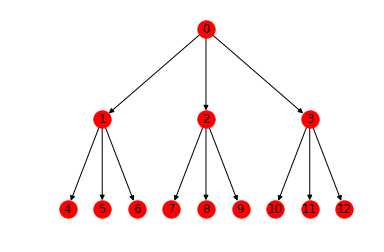

In [7]:
nice_tree_plot(tree)

## Extracting a tree from simulated data

In [8]:
num_docs = 50000
words_per_doc = 20
vocab_size = 100
topic_dirichlet = 0.1

In [9]:
def topic_func(node_id):
    topic = np.ones(vocab_size)
    topic[node_id % vocab_size] = 20.0
    topic /= topic.sum()
    return topic

#topic_func = None  # Use this line to use random topics instead

In [10]:
sampler = HPAM2Sampler(
    g = tree,
    num_docs = num_docs,
    words_per_doc = words_per_doc,
    vocab_size = vocab_size,
    topic_dirichlet = topic_dirichlet,
    topic_func = topic_func)

In [11]:
%%time
sampler.sample(); None

100%|██████████| 50000/50000 [01:59<00:00, 419.80it/s]

CPU times: user 1min 52s, sys: 7.98 s, total: 2min
Wall time: 1min 59s


In [12]:
%%time
data = lil_matrix((sampler.num_docs, sampler.vocab_size), dtype='float')
for doc_index, doc in enumerate(tqdm.tqdm(sampler.docs)):
    doc = sorted(doc)
    for vocab_index in doc:
        data[doc_index, vocab_index] += 1
data = csr_matrix(data)

100%|██████████| 50000/50000 [00:09<00:00, 5297.64it/s]


CPU times: user 9.42 s, sys: 172 ms, total: 9.59 s
Wall time: 9.77 s


In [13]:
num_digits = len(str(sampler.vocab_size - 1))
vocab = ["w{:0{}d}".format(i, num_digits) for i in range(sampler.vocab_size)]

In [14]:
K = len(tree.nodes())

In [15]:
analysis = Analysis(
    infile = data.transpose(),
    vocab_file = vocab,
    outfile = None,
    loss = "L2",
    K = K,
    seed = 100,
    eps = 1e-6,
    new_dim = 1000,
    max_threads = 8,
    anchor_thresh = min(int(num_docs * 0.05), 50),
    top_words = 10,
)

In [16]:
%%time
analysis.run();

Input matrix shape: (100, 50000)
identifying candidate anchors
100 candidates
Sum of entries in Q is  0.9999999999999853
Multiplying Q took  1.188918113708496 seconds
Q sum is 0.9999999999999853
done reading documents
anchors are:
0 w00
1 w05
2 w10
3 w09
4 w01
5 w03
6 w08
7 w12
8 w07
9 w06
10 w11
11 w02
12 w04
begin threaded recovery with 8 processors
0	-1	1.0
done recovering
w00 : w00 w20 w54 w28 w88 w64 w45 w67 w86 w38 
w05 : w05 w95 w98 w55 w18 w33 w47 w65 w99 w66 
w10 : w10 w25 w53 w59 w69 w46 w84 w20 w68 w15 
w09 : w09 w18 w91 w84 w70 w69 w67 w19 w99 w20 
w01 : w01 w42 w77 w94 w68 w59 w84 w69 w21 w83 
w03 : w03 w88 w91 w89 w95 w79 w23 w71 w56 w54 
w08 : w08 w38 w82 w32 w24 w21 w98 w97 w29 w17 
w12 : w12 w80 w70 w33 w90 w24 w79 w62 w81 w49 
w07 : w07 w94 w78 w67 w66 w50 w64 w14 w96 w49 
w06 : w06 w36 w19 w24 w22 w51 w83 w90 w92 w27 
w11 : w11 w37 w48 w71 w65 w92 w16 w27 w94 w77 
w02 : w02 w76 w34 w28 w62 w15 w40 w63 w36 w85 
w04 : w04 w72 w53 w48 w49 w61 w69 w43 w35 w64 
CPU times:

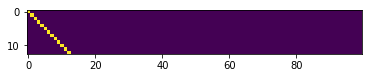

In [17]:
topics = np.array([sampler.topics[n] for n in tree.nodes()])
plt.imshow(topics);

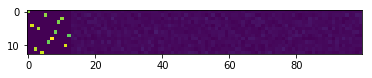

In [18]:
plt.imshow(analysis.A.T);

In [19]:
R = analysis.R

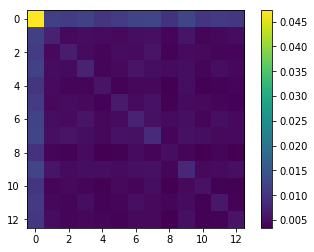

In [20]:
fig, ax = plt.subplots()
ax.imshow(R);
fig.colorbar(ax.get_images()[0]);

In [21]:
np.max(np.abs(R - R.T))

1.9081958235744878e-17

In [22]:
R.min(), R.max()

(0.003442300270212728, 0.047286243512458255)

In [23]:
R.sum()

1.0000246072163312

In [24]:
C = Aho.get_ratio_matrix(R)

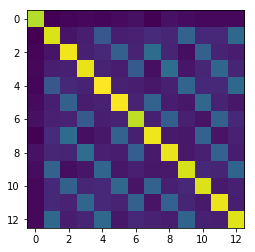

In [25]:
plt.imshow(C);

In [26]:
order = np.argmax(analysis.A, axis=0)
perm = invert_permutation(order)
perm

array([ 0,  4, 11,  5, 12,  1,  9,  8,  6,  3,  2, 10,  7])

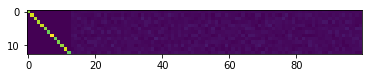

In [27]:
plt.imshow(analysis.A.T[perm, :]);

In [28]:
Rp = permute_square(analysis.R, perm = perm)

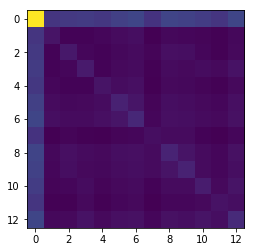

In [29]:
plt.imshow(Rp);

In [30]:
Cp = permute_square(C, perm=perm)

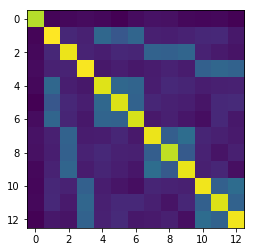

In [31]:
plt.imshow(Cp);

In [32]:
extracted_tree = Aho.extract(Cp)

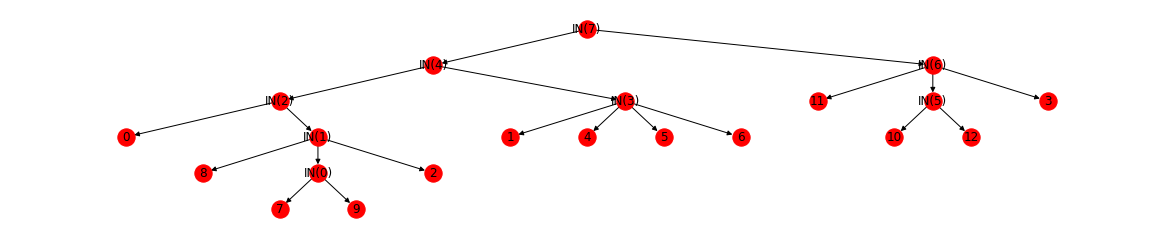

In [33]:
fig, ax = plt.subplots(figsize = (20,4))
nice_tree_plot(extracted_tree, ax=ax)

* TODO: extract tree from real data
* TODO: run the tree-building sequence on the above results

Need to diagnose results...
* incorrect topics?  (how to map recovered topics onto "expected" topics?)
  * topics with too much overlap?
    * try sparser dirichlet?
    * or try fixed topics, chosen specifically to have low overlap (this makes it easier to map recovered to expected)
* or: correct topics but noisy R estimation?  (throwing away too many triplets??)

To deal with noisy R estimation, may need to adapt algorithm to optimize some cost function
that treats triplets as soft constraints; optimize some kind of "cost function" at each recursive split.